In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

PATH_TO_DATA = '../data/'
PATH_TO_OUTPUT_DATA = '../output-data/'
PATH_TO_MODEL_DATA = '../model-data/'

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
MLB_DF = pd.read_csv(PATH_TO_OUTPUT_DATA + 'MLB_INPUT.csv')

In [4]:
features = MLB_DF.drop(labels = 
                       ['dt', 'Y', 'M', 'D', 'away_team', 
                        'home_team', 'away_pitcher_id', 'home_pitcher_id',
                       'date'],
                      axis = 1)

In [5]:
features

,outcome,home_AVG,home_OBP,home_SLG,away_AVG,away_OBP,away_SLG,AVG_difference,OBP_difference,SLG_difference,...,home_p_FIP,away_p_FIP,FIP_difference,FIP_difference_PCT,home_ELO,away_ELO,ELO_difference,E[ELO],home_rest,away_rest
0,1,0.273459,0.339283,0.466387,0.281519,0.349386,0.443116,-8.059871,-10.103320,23.270676,...,5.263956,5.052476,0.211481,4.017523,1496.828252,1462.450742,34.377511,0.597675,5,5
1,1,0.290176,0.357486,0.448264,0.267825,0.353322,0.450778,22.351406,4.164662,-2.514311,...,3.852216,4.278157,-0.425941,-11.057026,1487.470945,1529.964302,-42.493357,0.380077,5,5
2,1,0.276079,0.359380,0.468525,0.251828,0.327088,0.398252,24.251065,32.291929,70.272995,...,3.946850,4.643874,-0.697024,-17.660257,1544.173611,1478.296302,65.877309,0.681015,5,5
3,1,0.254198,0.336984,0.426431,0.243537,0.322708,0.400071,10.660336,14.276221,26.359450,...,4.260603,4.880234,-0.619630,-14.543251,1527.653270,1509.946671,17.706599,0.550788,5,5
4,0,0.272199,0.341041,0.443798,0.268227,0.342770,0.423582,3.971909,-1.728942,20.216091,...,5.442492,4.016318,1.426174,26.204427,1544.192550,1512.406489,31.786061,0.590480,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46123,1,0.256098,0.336957,0.443089,0.237903,0.325000,0.395161,18.194335,11.956522,47.928141,...,2.722657,4.390192,-1.667536,-61.246644,1539.697126,1535.818786,3.878340,0.511161,1,1
46124,1,0.230496,0.306709,0.421986,0.233202,0.331034,0.430830,-2.705127,-24.325218,-8.844224,...,4.390192,4.390192,0.000000,0.000000,1485.521165,1554.316475,-68.795310,0.311732,1,1
46125,1,0.218868,0.316832,0.373585,0.210970,0.280769,0.354430,7.897460,36.062452,19.154526,...,4.390192,4.390192,0.000000,0.000000,1525.656785,1443.713781,81.943004,0.719787,1,1
46126,0,0.196653,0.267176,0.334728,0.245059,0.345890,0.501976,-48.406569,-78.714838,-167.248251,...,4.390192,2.619793,1.770399,40.326226,1465.726121,1567.938914,-102.212794,0.235634,1,1


### Brief EDA

In [6]:
features['E[ELO]']

0        0.597675
1        0.380077
2        0.681015
3        0.550788
4        0.590480
           ...   
46123    0.511161
46124    0.311732
46125    0.719787
46126    0.235634
46127    0.310808
Name: E[ELO], Length: 46128, dtype: float64

In [7]:
import numpy as np
np.corrcoef([1 if x > .5 else 0 for x in features['E[ELO]']], features['outcome'])

array([[1.        , 0.08780784],
       [0.08780784, 1.        ]])

Thank you: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

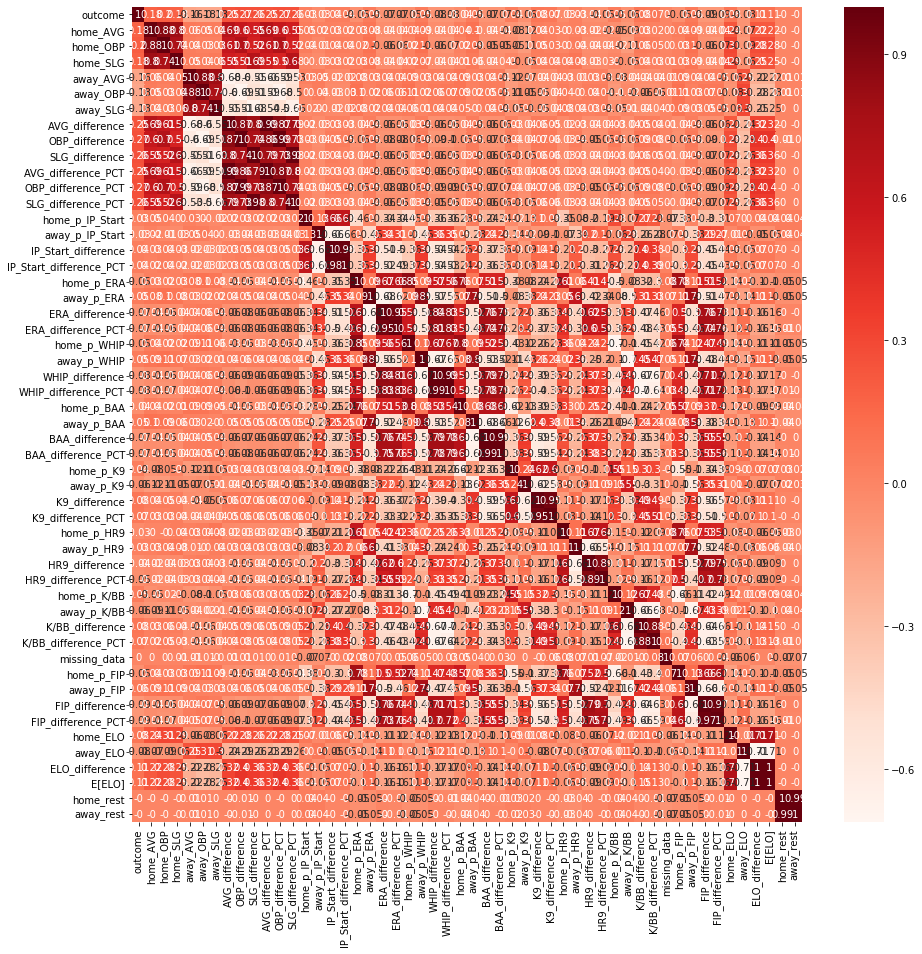

In [8]:
# correlation plots
plt.figure(figsize=(15,15))
cor = features.corr()
cor = cor.apply(lambda x: round(100*x)/100)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [17]:
#Correlation with output variable
cor_target = abs(cor['outcome'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target >= 0.2]
relevant_features

outcome               1.00
home_OBP              0.20
AVG_difference        0.25
OBP_difference        0.27
SLG_difference        0.26
AVG_difference_PCT    0.25
OBP_difference_PCT    0.27
SLG_difference_PCT    0.26
Name: outcome, dtype: float64

### SEPARATING DATA
Looking at PCT differences only

In [18]:
features['rest_difference'] = features['home_rest'] - features['away_rest']

In [19]:
features['ELO_difference_PCT'] = features['ELO_difference']/features['home_ELO']*100

In [20]:
PCT_DIFF = features[[i for i in list(features) if 'PCT' in i] + ['E[ELO]', 'rest_difference', 'outcome']]
PCT_DIFF_features = [i for i in list(features) if 'PCT' in i] + ['E[ELO]', 'rest_difference']

# REMOVING E[ELO] BEACUSE OF CORRELATION
PCT_DIFF = features[[i for i in list(features) if 'PCT' in i] + ['rest_difference', 'outcome']]
PCT_DIFF_features = [i for i in list(features) if 'PCT' in i] + ['rest_difference']

In [21]:
DIFF = features[[i for i in list(features) if (('difference' in i) & ('PCT' not in i))] + [
    'E[ELO]', 'outcome']]
DIFF_features = [i for i in list(features) if (('difference' in i) & ('PCT' not in i))] + [
    'E[ELO]']

In [22]:
# PCT DIFF
x1_train, x1_test, y1_train, y1_test = train_test_split(
    PCT_DIFF[PCT_DIFF_features], PCT_DIFF['outcome'], test_size = 0.2, random_state = 499
)

In [23]:
# DIFF
x2_train, x2_test, y2_train, y2_test = train_test_split(
    DIFF[DIFF_features], DIFF['outcome'], test_size = 0.2, random_state = 499
)

In [24]:
x2_train.describe()

,AVG_difference,OBP_difference,SLG_difference,IP_Start_difference,ERA_difference,WHIP_difference,BAA_difference,K9_difference,HR9_difference,K/BB_difference,FIP_difference,ELO_difference,rest_difference,E[ELO]
count,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000
mean,1.160181,2.268792,2.366647,0.003323,-0.007687,-0.002243,-0.000211,0.008495,0.000093,0.014424,-0.005391,0.054554,0.005176,0.500280
std,42.543584,46.087607,86.092328,0.669086,1.065112,0.194900,0.030183,1.810186,0.383530,1.352692,0.839026,47.091523,2.497672,0.126908
min,-164.641395,-174.070240,-374.873190,-5.033333,-6.760000,-1.154770,-0.148000,-8.682394,-2.027936,-14.008457,-4.167378,-176.250866,-182.000000,0.116175
25%,-26.769364,-28.262339,-53.739755,-0.325665,-0.622718,-0.117143,-0.017969,-1.052149,-0.222142,-0.567717,-0.495436,-31.666956,0.000000,0.409851
50%,0.982479,2.064271,2.190028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.547910,0.000000,0.501577
75%,29.100094,32.701229,58.540264,0.333333,0.620000,0.112651,0.017487,1.083285,0.222333,0.605694,0.489187,32.123743,0.000000,0.591420
max,182.095440,196.036498,330.407801,4.729310,6.062778,0.998780,0.148000,8.623066,1.899812,13.964935,5.000167,193.658080,189.000000,0.902874


In [25]:
x2_test.describe()

,AVG_difference,OBP_difference,SLG_difference,IP_Start_difference,ERA_difference,WHIP_difference,BAA_difference,K9_difference,HR9_difference,K/BB_difference,FIP_difference,ELO_difference,rest_difference,E[ELO]
count,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000
mean,1.447789,2.225630,2.422321,-0.012451,0.019276,0.005984,0.000465,-0.022792,0.000090,-0.032021,0.016201,-0.783147,-0.019185,0.497924
std,42.674185,46.434960,87.636766,0.651481,1.067677,0.194378,0.030317,1.793881,0.377867,1.355806,0.833396,47.175521,1.842221,0.127261
min,-157.251980,-177.993311,-405.340760,-4.835556,-6.062778,-0.857321,-0.117000,-7.836768,-1.643672,-13.290476,-4.046601,-176.250866,-175.000000,0.116175
25%,-25.757345,-28.421288,-55.148905,-0.347162,-0.610000,-0.106167,-0.017000,-1.093485,-0.223542,-0.625864,-0.472976,-32.855465,0.000000,0.406546
50%,1.263223,1.980373,2.732842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.747681,0.000000,0.497848
75%,29.122720,32.753217,59.091970,0.312446,0.650000,0.120666,0.018000,1.018903,0.222968,0.534525,0.510990,31.279419,0.000000,0.589069
max,162.071120,188.748137,317.577710,4.681992,6.470000,0.869880,0.141000,9.585648,2.027936,12.888590,4.015049,176.391970,4.000000,0.883992


# PCT_DIFF models

#### Logistic regression

```
>>> from sklearn.model_selection import cross_val_score
>>> clf = svm.SVC(kernel='linear', C=1)
>>> scores = cross_val_score(clf, X, y, cv=5)
```

In [66]:
# imports
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression as LogisticRegression
import math

In [97]:
X = PCT_DIFF[PCT_DIFF_features]
Y = PCT_DIFF['outcome']

In [52]:
# data: x1_train, x1_test, y1_train, y1_test
logit = LogisticRegression(
    penalty = 'l2', 
    fit_intercept = True,
    random_state = 499, 
)

In [53]:
logit.fit(x1_train, y1_train)
logit.score(x1_train, y1_train)

0.6234079453688147

In [51]:
scores = cross_val_score(logit, x1_train, y1_train, cv=5)
print("Accuracy: %0.3f (+/- %0.3f)" % (
    scores.mean(), scores.std() * 2))

Accuracy: 0.623 (+/- 0.009)


In [39]:
sum(logit.predict(x1_test) == y1_test)/len(y1_test)

0.6236722306525038

(array([  22.,  143.,  354.,  795., 1240., 1900., 2134., 1691.,  809.,
         138.]),
 array([0.02015563, 0.10728664, 0.19441764, 0.28154865, 0.36867965,
        0.45581066, 0.54294166, 0.63007267, 0.71720367, 0.80433468,
        0.89146568]),
 <a list of 10 Patch objects>)

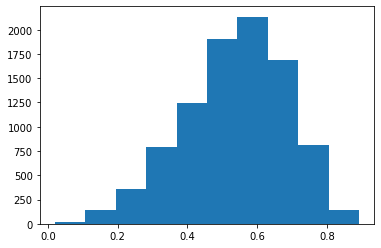

In [71]:
logit_probs = [math.exp(x)/(1 + math.exp(x)) for x in list((logit.decision_function(x1_test)))]
plt.hist(logit_probs)

In [90]:
y_pred =pd.DataFrame(dict(zip(logit_probs, y1_test)), 
             index = ['y']).T.reset_index().rename({'index': 'yhat'}, axis = 1)
y_pred['buckets'] = y_pred['yhat'].apply(lambda x: round(10*(x))/10)

In [94]:
y_pred.groupby('buckets')['y'].mean()

buckets
0.0    0.000000
0.1    0.232143
0.2    0.268966
0.3    0.312000
0.4    0.404335
0.5    0.497942
0.6    0.596535
0.7    0.697531
0.8    0.824859
0.9    0.913043
Name: y, dtype: float64

In [95]:
y_pred[y_pred.buckets > .8]

,yhat,y,buckets
30,0.850288,1,0.9
177,0.857731,1,0.9
180,0.862348,1,0.9
1288,0.891466,1,0.9
1672,0.858619,1,0.9
1953,0.866226,1,0.9
2069,0.865221,1,0.9
3766,0.863131,1,0.9
3808,0.861450,1,0.9
4021,0.871246,1,0.9


### Logit modeling based on time of season

In [107]:
x3_train = X[0:35000]
y3_train = Y[0:35000]
x3_test = X[35001:]
y3_test = Y[35001:]

In [108]:
logit.fit(x3_train, y3_train)
logit.score(x3_train, y3_train)

0.6231714285714286

In [109]:
scores = cross_val_score(logit, x3_train, y3_train, cv=5)
print("Accuracy: %0.3f (+/- %0.3f)" % (
    scores.mean(), scores.std() * 2))

Accuracy: 0.623 (+/- 0.015)


In [114]:
logit_probs = [math.exp(x)/(1 + math.exp(x)) for x in list((logit.decision_function(x3_test)))]
y_pred =pd.DataFrame(dict(zip(logit_probs, y3_test)), 
             index = ['y']).T.reset_index().rename({'index': 'yhat'}, axis = 1)
y_pred['buckets'] = y_pred['yhat'].apply(lambda x: round(25*(x))/25) # Apply top to the same value
y_pred.groupby('buckets')['y'].count()

buckets
0.04       9
0.08      25
0.12      55
0.16      99
0.20     138
0.24     235
0.28     305
0.32     429
0.36     520
0.40     630
0.44     777
0.48     897
0.52    1044
0.56    1106
0.60    1133
0.64    1039
0.68     888
0.72     751
0.76     591
0.80     312
0.84     110
0.88      23
0.92       1
Name: y, dtype: int64

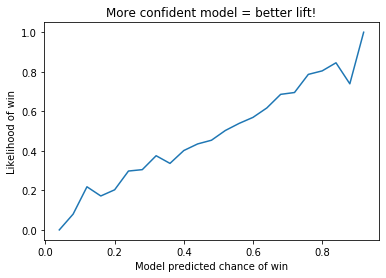

In [121]:
plt.plot(y_pred.groupby('buckets')['y'].mean())
plt.xlabel('Model predicted chance of win')
plt.ylabel('Likelihood of win')
plt.title('More confident model = better lift!')
plt.show()